# NASNetLarge transfer learning for Single cells

## Fine tune at 1000

In [1]:
# just as shown in https://keras.io/api/preprocessing/image/

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Tutorial starts here

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

#####  https://www.tensorflow.org/tutorials/images/transfer_learning
In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a ```tf.data.Dataset``` for training and validation using the ```tf.keras.preprocessing.image_dataset_from_directory``` utility. You can learn more about loading images in this tutorial.

In [4]:
# BATCH_SIZE = 32
BATCH_SIZE = 10
# IMG_SIZE = (160, 160)
IMG_SIZE = (331,331) # specific for NASNet

train_dataset = image_dataset_from_directory('../../../data_single/data_single_conv_split/train/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 569 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory('../../../data_single/data_single_conv_split/val/',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 100 files belonging to 2 classes.


Note that the class name is automatically set by the sub-folder name, and attached as label in the ```tf.data.Dataset``` objects.

In [6]:
print("type of train_dataset: ", type(train_dataset))
print("type of validation_dataset: ", type(validation_dataset))
# train_dataset.shape # ERROR: 'BatchDataset' object has no attribute 'shape'

type of train_dataset:  <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
type of validation_dataset:  <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [7]:
class_names = train_dataset.class_names
class_names

['par1', 'wt']

Show the first nine images and labels from the traning set.

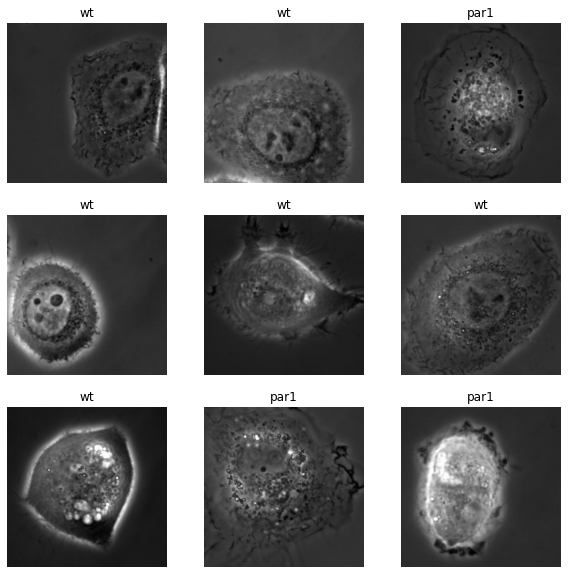

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set. ```tf.data.experimental.cardinality``` returns the cardinality (natural numbers) of ```dataset```.

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
test_dataset

<TakeDataset shapes: ((None, 331, 331, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


#### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide :https://www.tensorflow.org/guide/data_performance

In [12]:
# AUTOTUNE = tf.data.AUTOTUNE # worked at macpro but not in linux
AUTOTUNE = tf.data.experimental.AUTOTUNE # use instead this in linux

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this tutorial.

In [13]:
data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

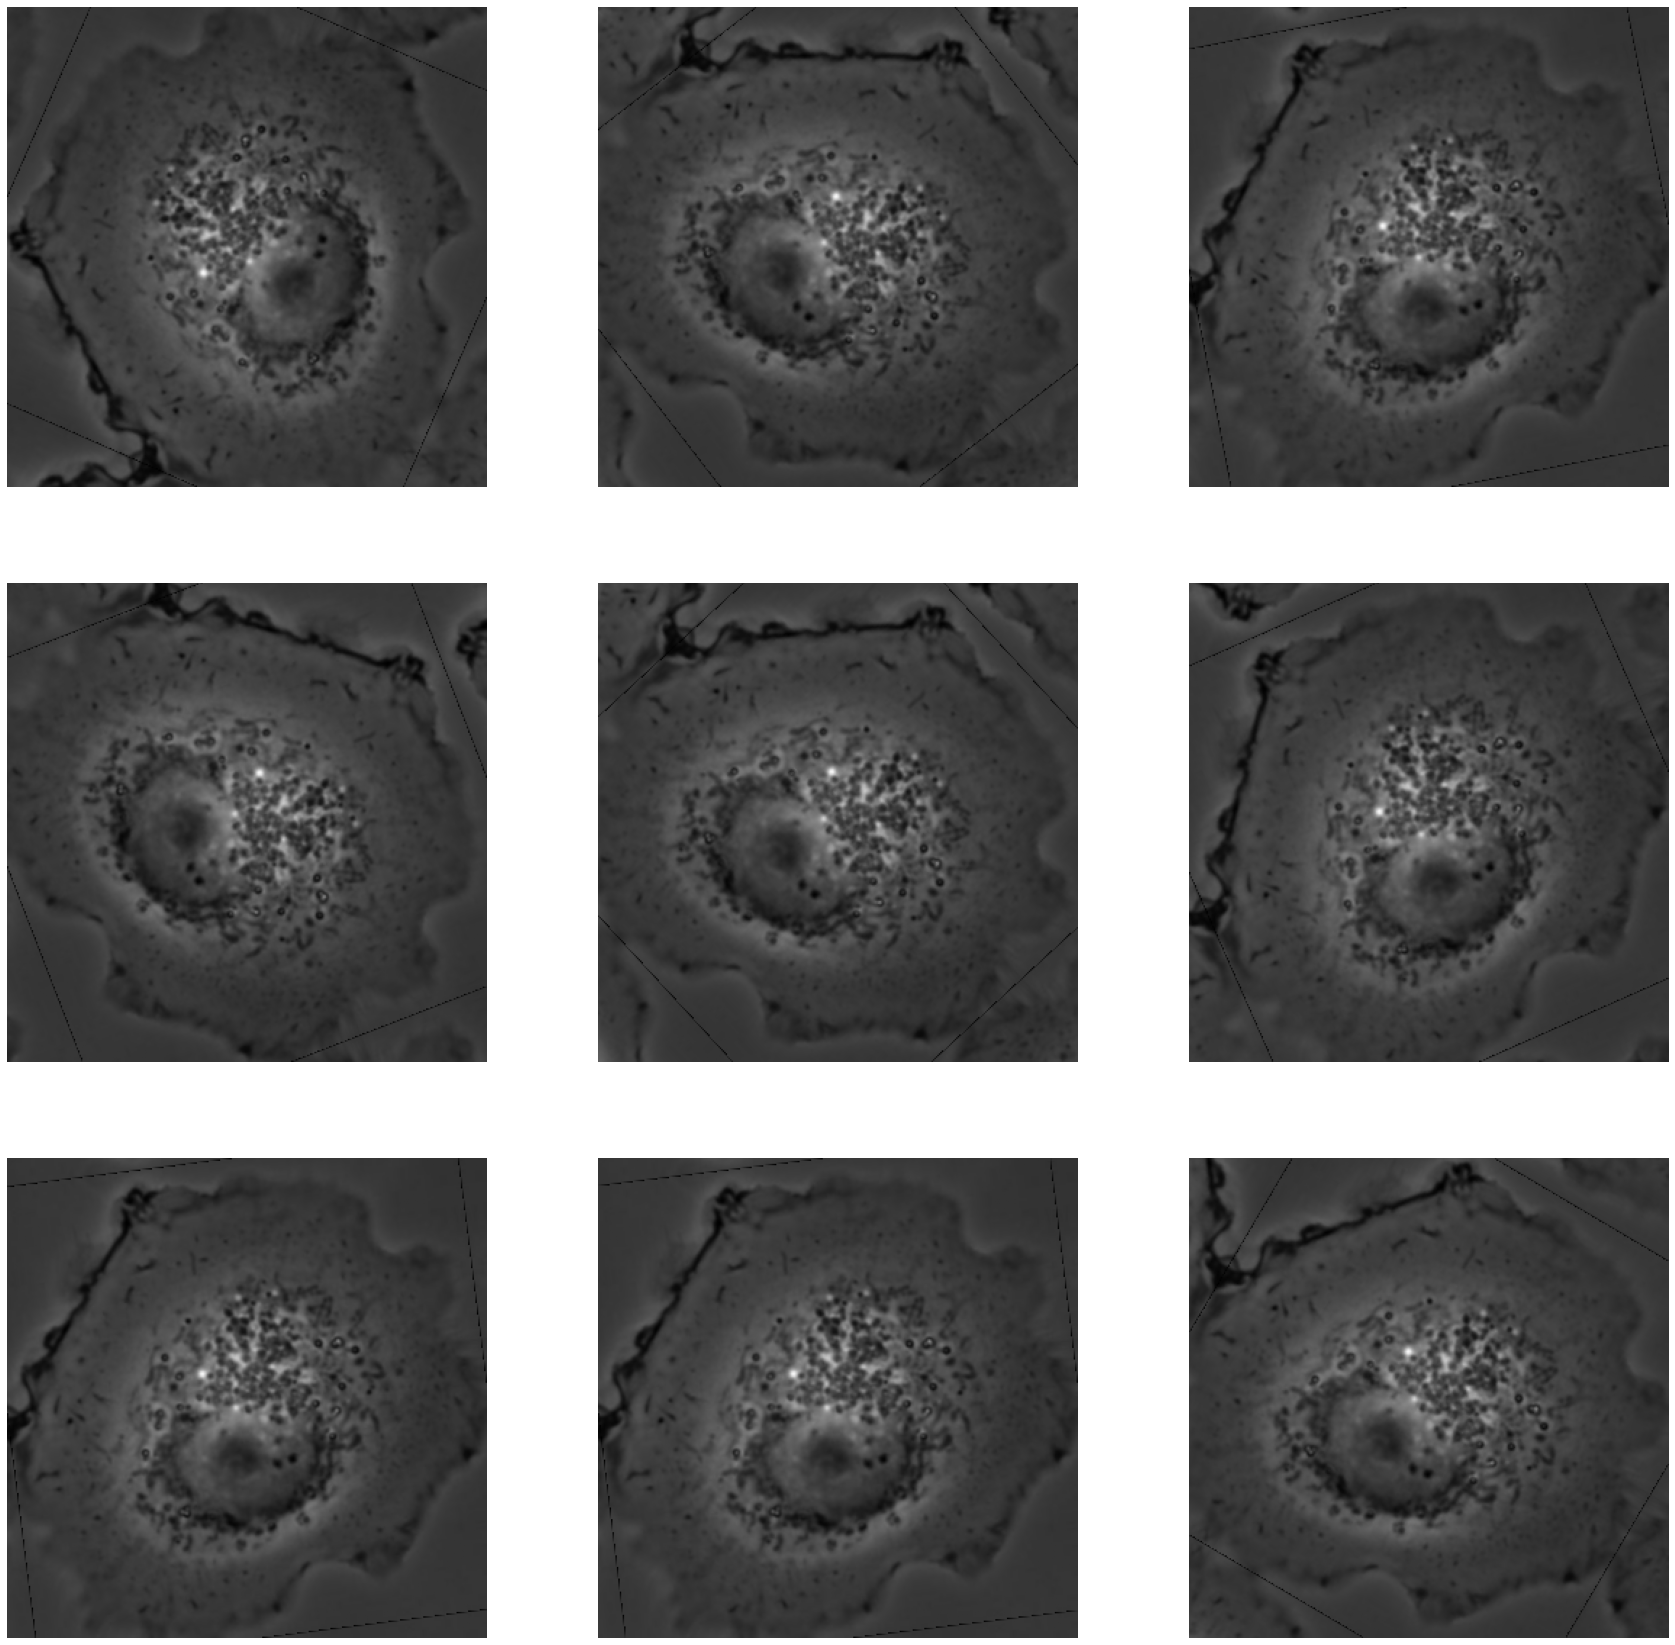

In [14]:
for image, _ in train_dataset.take(1):
      plt.figure(figsize=(30, 30))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

#### Rescale pixel values

In a moment, you will download ```tf.keras.applications.MobileNetV2``` for use as your base model. This model expects pixel values in ```[-1, 1]```, but at this point, the pixel values in your images are in ```[0-255]```. To rescale them, use the preprocessing method included with the model.

In [15]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## NasNetLarge

In [16]:
preprocess_input = tf.keras.applications.nasnet.preprocess_input

Alternatively, you could rescale pixel values from [0,255] to [-1,1] using a rescaling layer : https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling

In [17]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1,1] or [0,1], or use the included preprocess_input function.

#### Create the base model from the pre-trained covnets

You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like ```jackfruit``` and ```syringe```. This base of knowledge will help us classify cats and dogs form our specific dataset. 

First, you nee do pick which layer of MobileNet V2 you will use for feature exreaction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck" layer. The bottleneck layer features retain more generality a compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a neetwork that doesn't include the classification layers at the top, which is ideal for feature extraction. 

In [18]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.NASNetLarge(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [19]:
IMG_SIZE

(331, 331)

In [20]:
IMG_SHAPE

(331, 331, 3)

This feature extractor converts each ```160x160x3``` image into a ```5x5x2048``` block of features. Let's see what it does an exaple batch of images:

In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 11, 11, 4032)


#### Feature extraction


In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier. 

##### Freeze the convolutional base

It is important to freeze the convolutional base before you compile an train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's ```trainable``` flag to False will fressze all of them.

In [22]:
base_model.trainable = False

#### Important note about BatchNoramlization layers

Many models contain ```tf.keras.layers.BatchNormalization``` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as whon later in this tutorial. 

When you set ```layer.trainable=False```, the ```BatchNormalization``` layer will run in inference mode, and will not update its mean and variance statistics. 

When you *unfreeze* a model that contains BatchNormalization layers in order to do fine-tuning, you chould keep the BatchNormalization layers in inference mode by passing ```training=False``` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.  

In [23]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

activation_132 (Activation)     (None, 21, 21, 336)  0           adjust_bn_9[0][0]                
__________________________________________________________________________________________________
activation_134 (Activation)     (None, 21, 21, 336)  0           adjust_bn_9[0][0]                
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 21, 21, 336)  0           adjust_bn_9[0][0]                
__________________________________________________________________________________________________
activation_138 (Activation)     (None, 21, 21, 336)  0           normal_bn_1_9[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_left1_9 (None, 21, 21, 336)  121296      activation_130[0][0]             
__________________________________________________________________________________________________
separable_

__________________________________________________________________________________________________
adjust_conv_projection_12 (Conv (None, 21, 21, 336)  677376      activation_164[0][0]             
__________________________________________________________________________________________________
normal_conv_1_12 (Conv2D)       (None, 21, 21, 336)  677376      activation_165[0][0]             
__________________________________________________________________________________________________
adjust_bn_12 (BatchNormalizatio (None, 21, 21, 336)  1344        adjust_conv_projection_12[0][0]  
__________________________________________________________________________________________________
normal_bn_1_12 (BatchNormalizat (None, 21, 21, 336)  1344        normal_conv_1_12[0][0]           
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 21, 21, 336)  0           normal_bn_1_12[0][0]             
__________

Total params: 84,916,818
Trainable params: 0
Non-trainable params: 84,916,818
__________________________________________________________________________________________________


#### Add a classification head

To generate predictions from the block of features, average over the spatial ```5x5``` spatial locations, using a ```tf.keras.layers.GlobalAveragePooling``` layer to convert the features to a single 2048-element vector per image.

In [24]:
# the above 5x5 refers to the final output layer shown above model summary
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 4032)


Apply a ```tf.keras.layers.Dense``` layer to convert these features into a single prediction per image. You don;t need an activation function here because this prediction will be treated as a ```logit```, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


Build a model by chaining together the data augementation, rescaling, base_model and feature extractor layers using the keras functional API. As previously mentioned, use training=False as our model contains BatchNormalization layer.

In [26]:
inputs = tf.keras.Input(shape=(331, 331, 3)) # image size
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with ```from_logits=True``` since the model provides a linear output.

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 331, 331, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4032)             

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two ```tf.Variable``` object, the weights and biases.

In [29]:
len(model.trainable_variables)

2

#### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [30]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 1s 107ms/step - loss: 0.6715 - accuracy: 0.6000


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.60


In [32]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
57/57 [==============================] - 20s 352ms/step - loss: 0.7090 - accuracy: 0.5220 - val_loss: 0.6249 - val_accuracy: 0.6125
Epoch 2/10
57/57 [==============================] - 8s 137ms/step - loss: 0.6747 - accuracy: 0.5413 - val_loss: 0.5953 - val_accuracy: 0.5875
Epoch 3/10
57/57 [==============================] - 8s 138ms/step - loss: 0.6425 - accuracy: 0.5782 - val_loss: 0.5632 - val_accuracy: 0.6375
Epoch 4/10
57/57 [==============================] - 8s 138ms/step - loss: 0.6167 - accuracy: 0.6309 - val_loss: 0.5282 - val_accuracy: 0.6750
Epoch 5/10
57/57 [==============================] - 8s 140ms/step - loss: 0.5925 - accuracy: 0.6397 - val_loss: 0.4966 - val_accuracy: 0.7000
Epoch 6/10
57/57 [==============================] - 8s 140ms/step - loss: 0.5830 - accuracy: 0.6467 - val_loss: 0.4795 - val_accuracy: 0.7500
Epoch 7/10
57/57 [==============================] - 8s 140ms/step - loss: 0.5599 - accuracy: 0.6661 - val_loss: 0.4955 - val_accuracy: 0.7500
Epoch

#### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

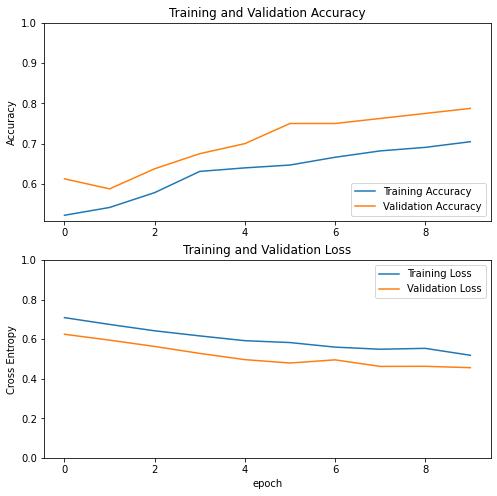

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Note: If you are wondering why the validation metrics are clearly better than 
# the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and 
# tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that hase trained slightly longer.

### Fine tuning

In the feature extraction experiment, you were only trianing a few layers on top of a MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the clssifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

*This should be only attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the geatures are inscreasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrtie the generic learning.

#### Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [36]:
base_model.trainable = True

In [37]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 1000

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  1039


#### Compile the model

As you are training a **much larger model** and want to readapt the pre-trained weights, **it is important to use a lower learning rateat this stage**. Otherwise, your model could overfit very quickly. 

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 331, 331, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4032)             

In [40]:
len(model.trainable_variables)

42

In [41]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
57/57 [==============================] - 14s 244ms/step - loss: 0.5031 - accuracy: 0.7083 - val_loss: 0.4559 - val_accuracy: 0.7500
Epoch 11/20
57/57 [==============================] - 8s 146ms/step - loss: 0.4645 - accuracy: 0.7557 - val_loss: 0.4077 - val_accuracy: 0.8250
Epoch 12/20
57/57 [==============================] - 8s 147ms/step - loss: 0.4537 - accuracy: 0.7504 - val_loss: 0.4147 - val_accuracy: 0.7875
Epoch 13/20
57/57 [==============================] - 8s 148ms/step - loss: 0.4371 - accuracy: 0.7856 - val_loss: 0.3439 - val_accuracy: 0.8625
Epoch 14/20
57/57 [==============================] - 8s 147ms/step - loss: 0.4029 - accuracy: 0.7926 - val_loss: 0.3551 - val_accuracy: 0.8375
Epoch 15/20
57/57 [==============================] - 8s 148ms/step - loss: 0.4009 - accuracy: 0.7979 - val_loss: 0.4139 - val_accuracy: 0.8000
Epoch 16/20
57/57 [==============================] - 8s 148ms/step - loss: 0.3734 - accuracy: 0.8190 - val_loss: 0.3432 - val_accuracy: 0.837

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting. 

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation st.

In [42]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

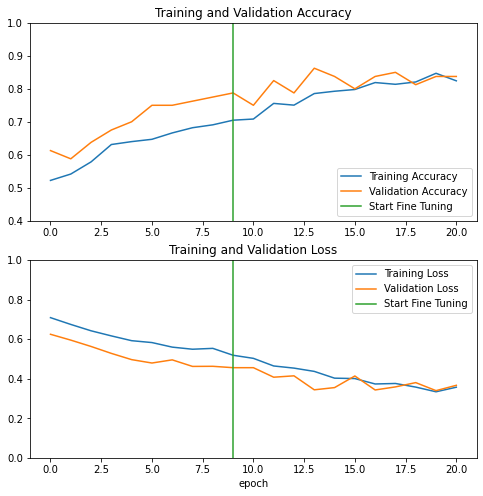

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluation and prediction

Finally, you can verify the performance of the model on new data using test set.

In [44]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 60ms/step - loss: 0.3958 - accuracy: 0.7500
Test accuracy : 0.75


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 0 1 0 0 1 0 0 1]
Labels:
 [0 0 0 1 1 1 1 0 0 1]


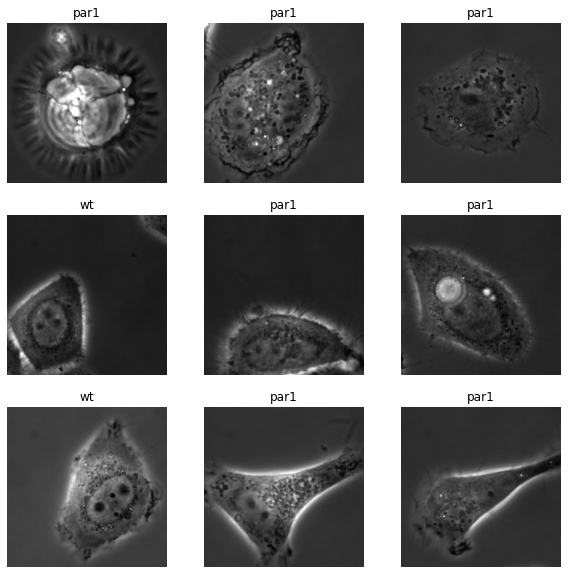

In [45]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [60]:
# import pickle
# with open("./linux_initial_history_saved/nasnetlarge_single_cell",'wb') as file_pi:
#     pickle.dump(history_fine.history, file_pi)

In [61]:
# test_load = pickle.load(open("./linux_initial_history_saved/nasnetlarge_single_cell",'rb'))
# test_load['loss']

[0.3652065396308899,
 0.2026711404323578,
 0.1427604705095291,
 0.1152363196015358,
 0.07440288364887238,
 0.04223112761974335,
 0.04997599124908447,
 0.0432465597987175,
 0.019247330725193024,
 0.018061179667711258,
 0.023171253502368927]